### install Facets
!pip install facets-overview==1.0.0

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import seaborn as sns

In [49]:
pd.options.display.max_rows = 10
# pd.options.display.float_format = '{:.1f}'.format
pd.options.display.float_format = '{:.4f}'.format

## Setup

In [3]:
from IPython.core.display import display, HTML
import base64
from facets_overview.feature_statistics_generator import FeatureStatisticsGenerator

### Load the Adult Dataset

With the modules now imported, we can load the Adult dataset into a pandas DataFrame data structure.

In [4]:
COLUMNS = ["age", "workclass", "fnlwgt", "education", "education_num",
           "marital_status", "occupation", "relationship", "race", "gender",
           "capital_gain", "capital_loss", "hours_per_week", "native_country",
           "income_bracket"]
train_csv = tf.keras.utils.get_file('adult.data', 
  'https://download.mlcc.google.com/mledu-datasets/adult_census_train.csv')
test_csv = tf.keras.utils.get_file('adult.data',
  'https://download.mlcc.google.com/mledu-datasets/adult_census_test.csv')

train_df = pd.read_csv(train_csv, names=COLUMNS, sep=r'\s*,\s*',
                      engine='python', na_values="?")
test_df = pd.read_csv(test_csv, names=COLUMNS, sep=r'\s*,\s*',
                     engine='python', na_values="?")

In [5]:
train_df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Analyzing the Adult Dataset with Facets

As mentioned in MLCC, it is important to understand your dataset *before* diving straight into the prediction task. 

Some important questions to investigate when auditing a dataset for fairness:

* **Are there missing feature values for a large number of observations?**
* **Are there features that are missing that might affect other features?**
* **Are there any unexpected feature values?**
* **What signs of data skew do you see?**

## Visualize the Data in Facets

In [6]:
fsg = FeatureStatisticsGenerator()
dataframes = [
    {'table': train_df, 'name':'trainData'} ]
censusProto = fsg.ProtoFromDataFrames(dataframes)
protostr = base64.b64encode(censusProto.SerializeToString()).decode('utf-8')

HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))

### FairAware Task #1

Review the descriptive statistics and histograms for each numerical and continuous feature. Click the **Show Raw Data** button above the histograms for categorical features to see the distribution of values per category.

Then, try to answer the following questions from earlier:

1. Are there missing feature values for a large number of observations?
2. Are there features that are missing that might affect other features?
3. Are there any unexpected feature values?
4. What signs of data skew do you see?

In [7]:
train_df.to_csv('train.csv', index=False)

In [8]:
train_df.describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,32561.0,32561.0,32561.0,32561.0,32561.0,32561.0
mean,38.6,189778.4,10.1,1077.6,87.3,40.4
std,13.6,105550.0,2.6,7385.3,403.0,12.3
min,17.0,12285.0,1.0,0.0,0.0,1.0
25%,28.0,117827.0,9.0,0.0,0.0,40.0
50%,37.0,178356.0,10.0,0.0,0.0,40.0
75%,48.0,237051.0,12.0,0.0,0.0,45.0
max,90.0,1484705.0,16.0,99999.0,4356.0,99.0


In [9]:
train_df.dropna(how="any", axis=0, inplace=True)

In [10]:
#@title Set the Number of Data Points to Visualize in Facets Dive

SAMPLE_SIZE = 5000 #@param
  
train_dive = train_df.sample(SAMPLE_SIZE).to_json(orient='records')

HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-dive id="elem" height="600"></facets-dive>
        <script>
          var data = {jsonstr};
          document.querySelector("#elem").data = data;
        </script>"""
html = HTML_TEMPLATE.format(jsonstr=train_dive)
display(HTML(html))

### Convert Adult Dataset into Tensors
We first have to define our input fuction, which will take the Adult dataset that is in a pandas DataFrame and convert it a Numpy array. 

While a pandas DataFrame is great — especially when working with Facets and other Python modules that visualize data — `tf.keras.Sequential` doesn't accept a pandas DataFrame as a data type. Luckily for us, it's quite trivial to convert a pandas DataFrame into a Numpy array, which is an accepted data type.

In [11]:
def pandas_to_numpy(data):
    # Drop empty rows
    data = data.dropna(how='any', axis=0)
    
    # Separate DataFrame into two Numpy arrays
    labels = np.array(data['income_bracket'] == '>50K')
    features = data.drop('income_bracket', axis=1)
    features = {name:np.array(value) for name, value in features.items()}
    
    return features, labels

### Represent Features in TensorFlow
TensorFlow requires that data maps to a model. To accomplish this, you have to use ```tf.feature_columns``` to ingest and represent features in TensorFlow.

### Create categorical feature columns

Since we <span style="color:red">don't know the full range of possible values</span> with occupation and native_country, we'll <span style="color:red">use categorical_column_with_hash_bucket()</span> to help map each feature string into an integer ID.

In [12]:
occupation = tf.feature_column.categorical_column_with_hash_bucket(
    'occupation', hash_bucket_size=1000)
native_country = tf.feature_column.categorical_column_with_hash_bucket(
    'native_country', hash_bucket_size=1000)

For the remaining categorical features, since we <span style='color:red'>know what the possible values</span> are, we can be more explicit and use <span style="color:red">categorical_column_with_vocabulary_list()</span>

In [13]:
gender = tf.feature_column.categorical_column_with_vocabulary_list('gender', ['Female', 'Male'])
race = tf.feature_column.categorical_column_with_vocabulary_list(
    'race', ["White", "Asian-Pac-Islander", "Amer-Indian-Eskimo", "Other", "Black"])
education = tf.feature_column.categorical_column_with_vocabulary_list(
    'education', ["Bachelors", "HS-grad", "11th", "Masters", "9th", "Some-college", 
                  "Assoc-acdm", "Assoc-voc", "7th-8th", "Doctorate", "Prof-school",
                  "5th-6th", "10th", "1st-4th", "Preschool", "12th"])
marital_status = tf.feature_column.categorical_column_with_vocabulary_list(
    "marital_status", ["Married-civ-spouse", "Divorced", "Married-spouse-absent",
                       "Never-married", "Separated", "Married-AF-spouse", "Widowed"])
relationship = tf.feature_column.categorical_column_with_vocabulary_list(
    "relationship", ["Husband", "Not-in-family", "Wife", "Own-child", "Unmarried", 
                     "Other-relative"])
workclass = tf.feature_column.categorical_column_with_vocabulary_list(
    "workclass", ["Self-emp-not-inc", "Private", "State-gov", "Federal-gov",
                  "Local-gov", "?", "Self-emp-inc", "Without-pay", "Never-worked"])

### Create numeric feature columns
<span style='color:red'>For Numeric features</span> we can just call on <span style='color:red'>feature_column.numeric_column()</span> to use its raw value instead of having to create a map between value and ID.

In [14]:
age = tf.feature_column.numeric_column('age')
fnlwgt = tf.feature_column.numeric_column('fnlwgt')
education_num = tf.feature_column.numeric_column("education_num")
capital_gain = tf.feature_column.numeric_column("capital_gain")
capital_loss = tf.feature_column.numeric_column("capital_loss")
hours_per_week = tf.feature_column.numeric_column("hours_per_week")

###  Make Age a Categorical Feature

If you chose `age`, you will have noticed that we suggested *bucketing* (also known as *binning*) this feature, grouping together similar ages into different groups. This might help the model generalize better across age. As such, we will convert `age` from a numeric feature (technically, an [ordinal feature](https://en.wikipedia.org/wiki/Ordinal_data)) to a categorical feature.

In [15]:
age_buckets = tf.feature_column.bucketized_column(age, boundaries = [18, 25, 30, 35, 40, 45, 50, 55, 60, 65])

### Define the Model Features

Now we can explicitly define which feature we will include in our model.

We'll consider `gender` a subgroup and save it in a separate `subgroup_variables` list, so we can add special handling for it as needed.

In [16]:
# List of variables, with special handling for gender subgroup.
variables = [native_country, education, occupation, workclass, relationship, age_buckets]
subgroup_variables = [gender]
feature_columns = variables + subgroup_variables

### Train a Deep Neural Net Model on Adult Dataset

With the features now ready to go, we can try predicting income using deep learning.

For the sake of simplicity, we are going to keep the neural network architecture light by simply **defining a feed-forward neural network with two hidden layers**.

But first, we have to convert our high-dimensional categorical features into a low-dimensional and dense real-valued vector, which we call an embedding vector. Luckily, <span style='color:red'>**```indicator_column```** (think of it as one-hot encoding)</span> and <span style='color:red'>**```embedding_column```** (that converts sparse features into dense features)</span> helps us streamline the process.

Based on our analysis of the data set from previous FairAware Tasks, we are going to move forward with the following features:

*   `workclass`
*   `education`
*   `age_buckets`
*   `relationship`
*   `native_country`
*   `occupation`

All other features will be omitted from training — but you are welcome to experiment. `gender` is the only feature that will be used to filter the test set for subgroup evaluation purposes.

In [17]:
deep_columns = [
    tf.feature_column.indicator_column(workclass),
    tf.feature_column.indicator_column(education),
    tf.feature_column.indicator_column(age_buckets),
    tf.feature_column.indicator_column(relationship),
    tf.feature_column.embedding_column(native_country, dimension=8),
    tf.feature_column.embedding_column(occupation, dimension=8)
]

In [78]:
# Define Deep Neural Net Model

# Parameters from form fill-ins
HIDDEN_UNITS_LAYER_01 = 128 #@param
HIDDEN_UNITS_LAYER_02 = 64 #@param
LEARNING_RATE = 0.1 #@param
L1_REGULARIZATION_STRENGTH = 0.001 #@param
L2_REGULARIZATION_STRENGTH = 0.001 #@param

RANDOM_SEED = 512
tf.random.set_seed(RANDOM_SEED)

# List of built-in metrics that we'll need to evaluate performance.
METRICS = [
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.FalseNegatives(name='fn'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
]

regularizer = tf.keras.regularizers.l1_l2(
    l1=L1_REGULARIZATION_STRENGTH, l2=L2_REGULARIZATION_STRENGTH)

model = tf.keras.Sequential([
    layers.DenseFeatures(deep_columns), 
    layers.Dense(HIDDEN_UNITS_LAYER_01, activation='relu', kernel_regularizer=regularizer),
    layers.Dense(HIDDEN_UNITS_LAYER_02, activation='relu', kernel_regularizer=regularizer),
    layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizer)])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
              optimizer=tf.keras.optimizers.Adagrad(LEARNING_RATE), 
              metrics=METRICS)

In [79]:
EPOCHS = 50
BATCH_SIZE = 500

feature, labels = pandas_to_numpy(train_df)
history = model.fit(feature, labels, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/50
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
61/61 [==============================] - 8s 10ms/step - loss: 1.8383 - tp: 1298.0000 - tn: 21976.0000 - fp: 678.0000 - fn: 6210.0000 - accuracy: 0.7716 - precision: 0.6569 - recall: 0.1729 - auc: 0.7895
Epoch 2/50
61/61 [==============================] - 1s 10ms/step - loss: 1.4138 - tp: 3721.0000 - tn: 21145.0000 - fp: 1509.0000 - fn: 3787.0000 - accuracy: 0.8244 - precision: 0.7115 - recall: 0.4956 - auc: 0.8669
Epoch 3/50
61/61 [==============================] - 1s 9ms/step - loss: 1.1150 - tp: 3978.0000 - tn: 21042.0000 - fp: 1612.0000 - fn: 3530.0000 - accuracy: 0.8295 - precision: 0.7116 - recall: 0.5298 - auc: 0.8756
Epoch 4/50
61/61 [==============================] - 1s 10ms/step - loss: 0.8828 - tp: 4004.0000 - tn: 21003.0000 - fp: 1651.0000 - fn: 3504.0000 - accuracy: 0.8291 - precision: 0.7080 - recall: 0.5333 - auc: 0.8772
Epoch 5/50
61/61 [==============

61/61 [==============================] - 1s 9ms/step - loss: 0.3995 - tp: 4124.0000 - tn: 20967.0000 - fp: 1687.0000 - fn: 3384.0000 - accuracy: 0.8319 - precision: 0.7097 - recall: 0.5493 - auc: 0.8829
Epoch 28/50
61/61 [==============================] - 1s 8ms/step - loss: 0.3990 - tp: 4155.0000 - tn: 20944.0000 - fp: 1710.0000 - fn: 3353.0000 - accuracy: 0.8321 - precision: 0.7084 - recall: 0.5534 - auc: 0.8831
Epoch 29/50
61/61 [==============================] - 1s 9ms/step - loss: 0.3988 - tp: 4174.0000 - tn: 20987.0000 - fp: 1667.0000 - fn: 3334.0000 - accuracy: 0.8342 - precision: 0.7146 - recall: 0.5559 - auc: 0.8832
Epoch 30/50
61/61 [==============================] - 1s 10ms/step - loss: 0.3983 - tp: 4167.0000 - tn: 20946.0000 - fp: 1708.0000 - fn: 3341.0000 - accuracy: 0.8326 - precision: 0.7093 - recall: 0.5550 - auc: 0.8833
Epoch 31/50
61/61 [==============================] - 1s 12ms/step - loss: 0.3982 - tp: 4137.0000 - tn: 20992.0000 - fp: 1662.0000 - fn: 3371.0000 - acc

In [20]:
# Evaluate Deep Neural Net Performance

features, labels = pandas_to_numpy(test_df)
model.evaluate(x=features, y=labels);

Consider rewriting this model with the Functional API.
943/943 [==============================] - 8s 6ms/step - loss: 0.4250 - tp: 4310.0000 - tn: 20760.0000 - fp: 1894.0000 - fn: 3198.0000 - accuracy: 0.8312 - precision: 0.6947 - recall: 0.5741 - auc: 0.8815


You can try retraining the model using different parameters. If you leave the parameters as is, then you see that this relatively simple deep neural net does a decent job in predicting income with an **overall accuracy of 0.8317** and an **AUC of 0.8817**. 

**But evaluation metrics with respect to subgroups are missing.** We will cover some of the ways you can evaluate at the subgroup level in the next section.

In [30]:
history.history.keys()

dict_keys(['loss', 'tp', 'tn', 'fp', 'fn', 'accuracy', 'precision', 'recall', 'auc'])

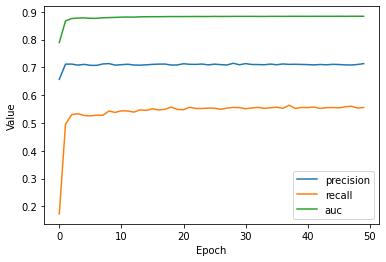

In [86]:
def plot_curve(history):
    epoch = history.epoch
    label = list(history.history.keys())
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    df = pd.DataFrame(history.history)
    
    for m in label[6:9]:
#         val = df[m]/df[m].mean()
        val = df[m]
        plt.plot(epoch, val, label=m)

    plt.legend()
plot_curve(history)

### Plot the Confusion Matrix

Since we've already defined which metrics we're interested in back when we defined and compiled our model, all we have to do now is:


1.   Define a function that will help us visualize the heatmap.
2.   Select which subgroup we're interested in, then pass that subgroup selection into `tf.keras.Model.predict()` for evaluation.

### Define Function to Visualize Binary Confusion Matrix

In [89]:
def plot_confusion_matrix(confusion_matrix, class_names, subgroup, figsize=(8,6)):
  # We're taking our calculated binary confusion matrix that's already in the 
  # form of an array and turning it into a pandas DataFrame because it's a lot 
  # easier to work with a pandas DataFrame when visualizing a heat map in 
  # Seaborn.
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    
    rcParams.update({'font.family':'sans-serif', 'font.sans-serif':['Liberation Sans']})
    
    sns.set_context('notebook', font_scale=1.25)
    
    fig = plt.figure(figsize=figsize)
    
    plt.title('Confusion Matrix for Performance Across ' + subgroup)
    
    #Combine the instance (numerical value) with its description
    strings = np.asarray([['True Positives', 'False negatives'],
                          ['False Positives', 'True Negatives']])
    labels = (np.asarray(['{0:g}\n{1}'.format(value, string) for string, 
                          value in zip(strings.flatten(), confusion_matrix.flatten())])).reshape(2,2)
    
    heatmap = sns.heatmap(df_cm, annot=labels, fmt='',
                         linewidths=2.0, cmap=sns.color_palette('GnBu_d'));
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
    
    plt.ylabel('References')
    plt.xlabel('Predictions')
    
    return fig 

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


,ACCURACY,PRECISION,RECALL,AUC
Male,0.7957,0.7092,0.5915,0.8584


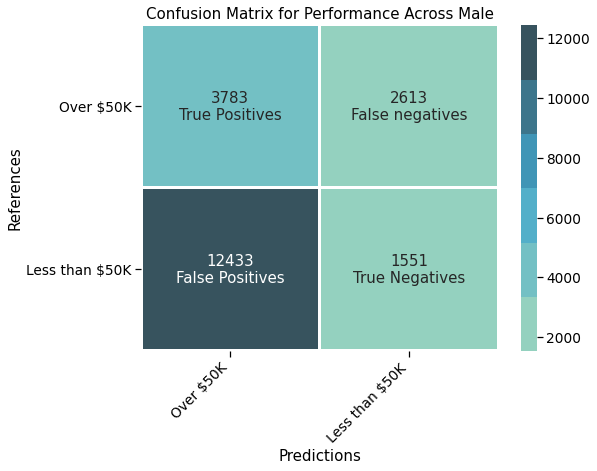

In [90]:
# Visualize Binary Confusion Matrix and Compute Evaluation Metrics Per Subgroup
CATEGORY  =  "gender" #@param {type:"string"}
SUBGROUP =  "Male" #@param {type:"string"}

# Labels for annotating axes in plot.
classes = ['Over $50K', 'Less than $50K']

# Given define subgroup, generate predictions and obtain its corresponding ground truth.
subgroup_filter  = test_df.loc[test_df[CATEGORY] == SUBGROUP]
features, labels = pandas_to_numpy(subgroup_filter)
subgroup_results = model.evaluate(x=features, y=labels, verbose=0)
confusion_matrix = np.array([[subgroup_results[1], subgroup_results[4]], 
                             [subgroup_results[2], subgroup_results[3]]])

subgroup_performance_metrics = {
    'ACCURACY': subgroup_results[5],
    'PRECISION': subgroup_results[6], 
    'RECALL': subgroup_results[7],
    'AUC': subgroup_results[8]
}
performance_df = pd.DataFrame(subgroup_performance_metrics, index=[SUBGROUP])
pd.options.display.float_format = '{:,.4f}'.format

plot_confusion_matrix(confusion_matrix, classes, SUBGROUP);
performance_df

,ACCURACY,PRECISION,RECALL,AUC
Female,0.9144,0.7007,0.4317,0.9098


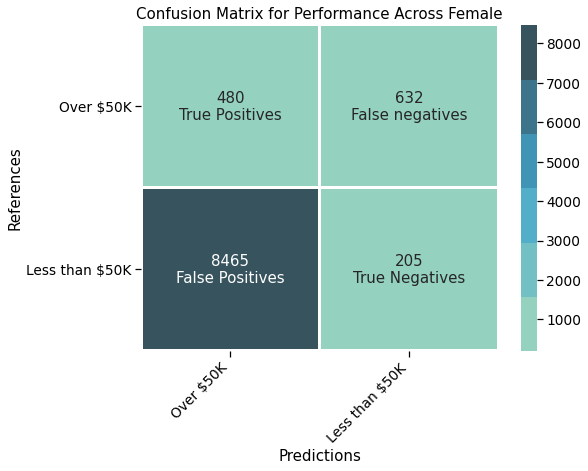

In [91]:
# Visualize Binary Confusion Matrix and Compute Evaluation Metrics Per Subgroup
CATEGORY  =  "gender" #@param {type:"string"}
SUBGROUP =  "Female" #@param {type:"string"}

# Labels for annotating axes in plot.
classes = ['Over $50K', 'Less than $50K']

# Given define subgroup, generate predictions and obtain its corresponding ground truth.
subgroup_filter  = test_df.loc[test_df[CATEGORY] == SUBGROUP]
features, labels = pandas_to_numpy(subgroup_filter)
subgroup_results = model.evaluate(x=features, y=labels, verbose=0)
confusion_matrix = np.array([[subgroup_results[1], subgroup_results[4]], 
                             [subgroup_results[2], subgroup_results[3]]])

subgroup_performance_metrics = {
    'ACCURACY': subgroup_results[5],
    'PRECISION': subgroup_results[6], 
    'RECALL': subgroup_results[7],
    'AUC': subgroup_results[8]
}
performance_df = pd.DataFrame(subgroup_performance_metrics, index=[SUBGROUP])
pd.options.display.float_format = '{:,.4f}'.format

plot_confusion_matrix(confusion_matrix, classes, SUBGROUP);
performance_df